In [9]:
import keras as keras
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, BatchNormalization
from keras.initializers import glorot_uniform
from keras.initializers import Constant
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.datasets import cifar10, mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Resizing, RandomCrop, RandomFlip, RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import math
from IPython.display import Image
import time 

##### VGGNet : 매우 단순하고 고전적인 구조

# GoogLenet

> * 1x1의 장점 <br> 
channel수 조절 <br>
연산량 감소(Effcient) <br>
비선형성(Non-Lineartiy)

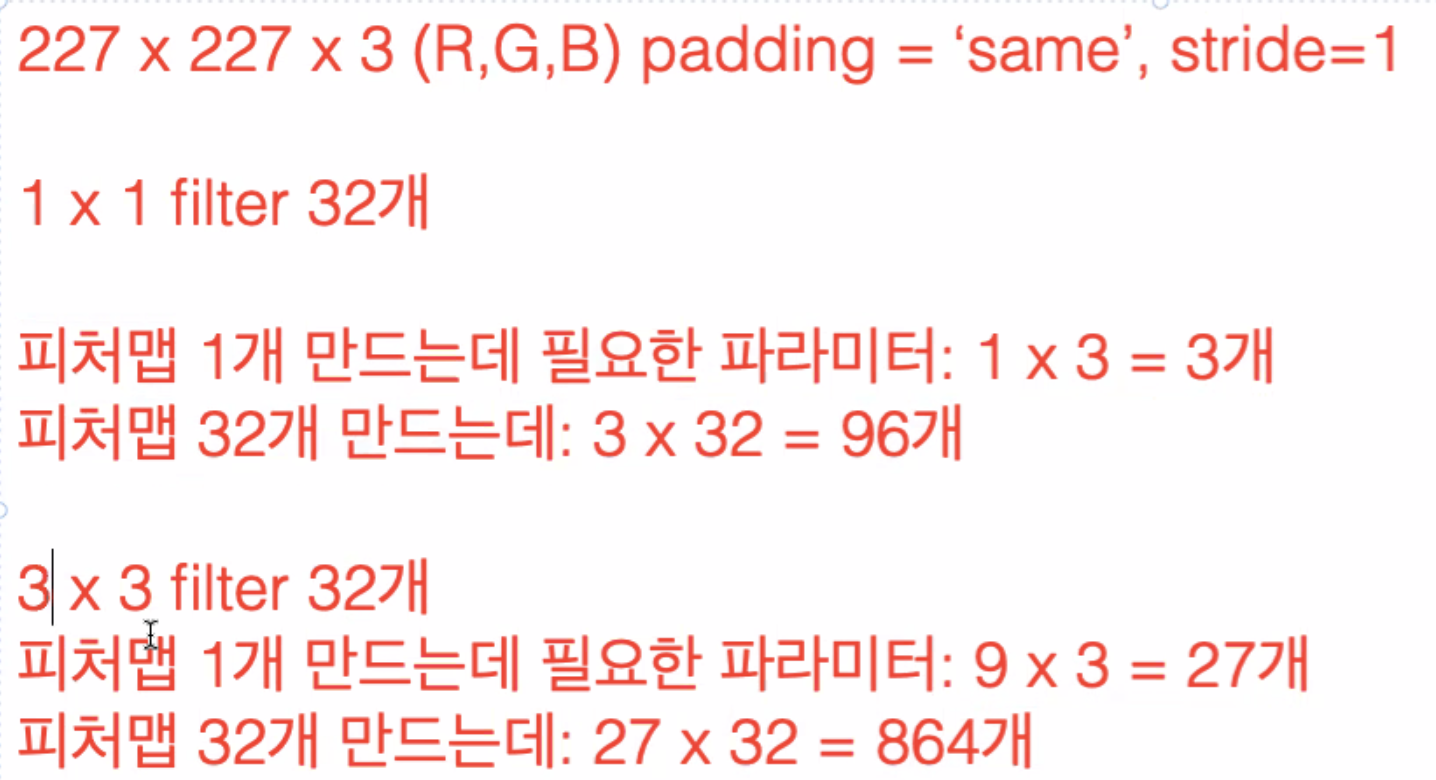

In [3]:
Image('./JupyterImage/221206/GoogLeNet.png')

## Data Load

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ti = x_train[0]
print(ti.shape)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

def augmentattion(x_train, y_train, resizing) :
    
    model = Sequential([Rescaling(1/255.),
                        resizing,
                       RandomCrop(32,32), # 32 X 32로 조정되어 중심축이 변경되며 일부가 잘려진다.
                       RandomFlip('horizontal'),
                       RandomRotation(np.random.randint(0,360))])

    Model.build(model, (1, ti.shape[0], ti.shape[1], 3)) # 3차원
    
    globals()[f"x_train_2"] = model(x_train)
                
    # 데이터 결합
    globals()[f"x_train_all"] = np.concatenate((x_train, x_train_2), axis=0)
    globals()[f"y_train_all"] = np.concatenate((y_train, y_train), axis=0)
    
    
    
resizing = Resizing(int(ti.shape[0]*1.1), int(ti.shape[1]*1.1)) 
augmentattion(x_train, y_train, resizing)

(32, 32, 3)
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


2022-12-07 09:26:11.788100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-12-07 09:26:16.413603: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9


### Resizing data 

In [16]:
num_classes = 10

def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

X_train, y_train, X_test, y_test = load_cifar10_data(224, 224)

# GooglLeNet 생성

In [10]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [11]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', 
                       kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

# Official

/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


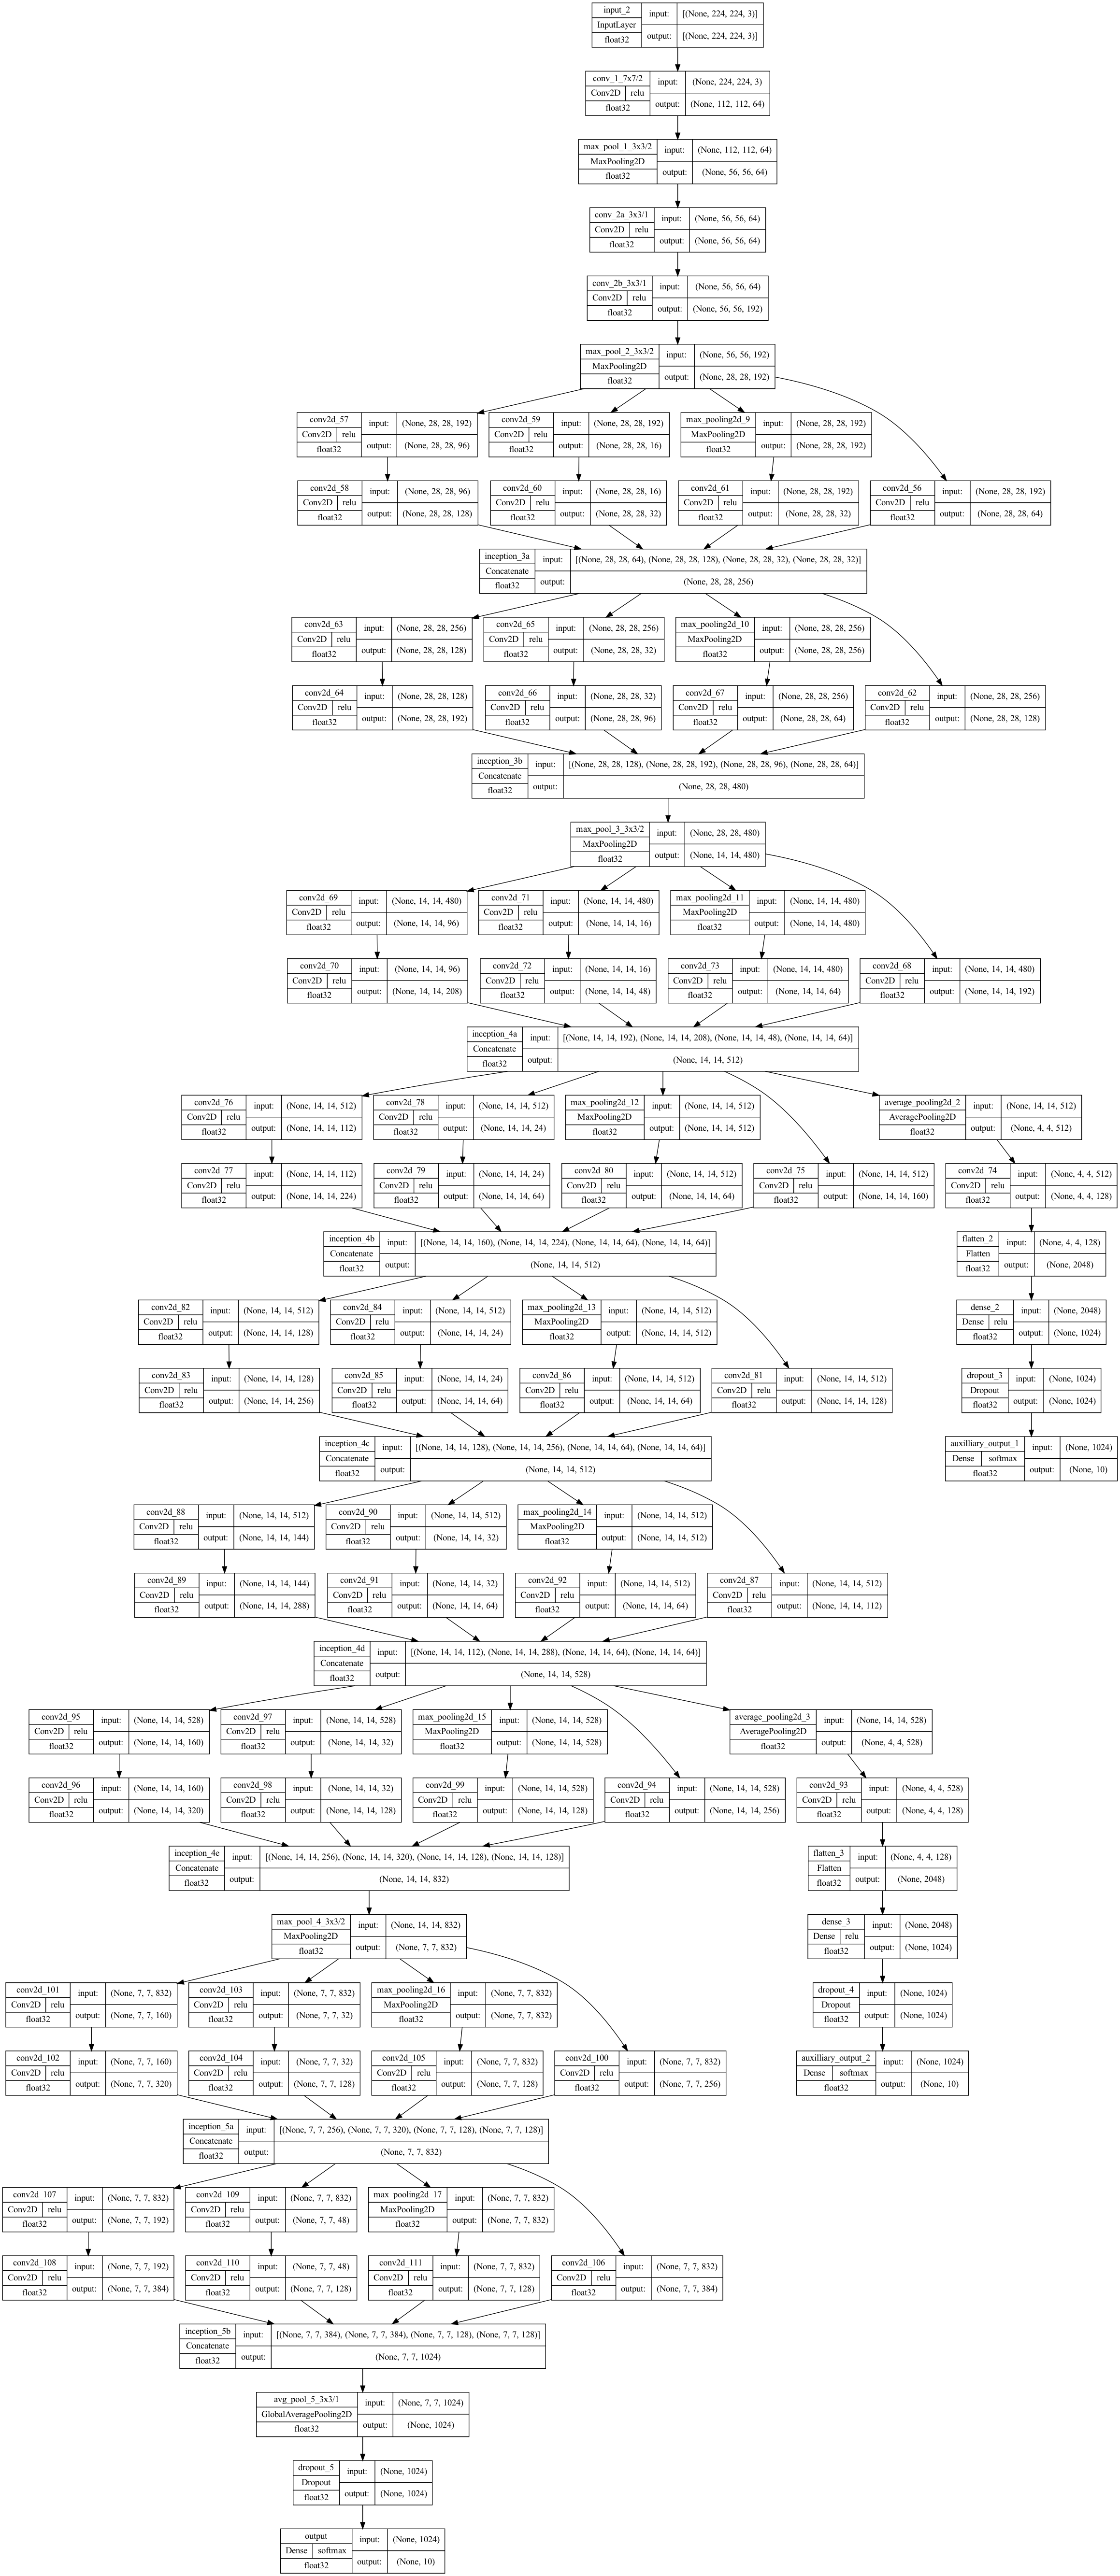

In [8]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

model = Model(input_layer, [x, x1, x2], name='inception_v1')

plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

### model complie

In [20]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
              loss_weights=[1, 0.3, 0.3], 
              optimizer=sgd, metrics=['accuracy'])

/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### model fit

In [21]:
history = model.fit(X_train, [y_train, y_train, y_train], 
                    validation_data = (X_test, [y_test, y_test, y_test]), 
                    epochs=epochs, batch_size=256, callbacks=[lr_sc])



Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/25
113/196 [================>.............] - ETA: 18:45 - loss: 3.6835 - output_loss: 2.3128 - auxilliary_output_1_loss: 2.2808 - auxilliary_output_2_loss: 2.2880 - output_accuracy: 0.1185 - auxilliary_output_1_accuracy: 0.1284 - auxilliary_output_2_accuracy: 0.1249

KeyboardInterrupt: 

# user made

#### model3
> filter의 사이즈가 클 수록 (가로 x 세로) 사이즈가 작아진다. <br>
padding을 same으로 넣어 너무 축소되는 것을 방지. <br>



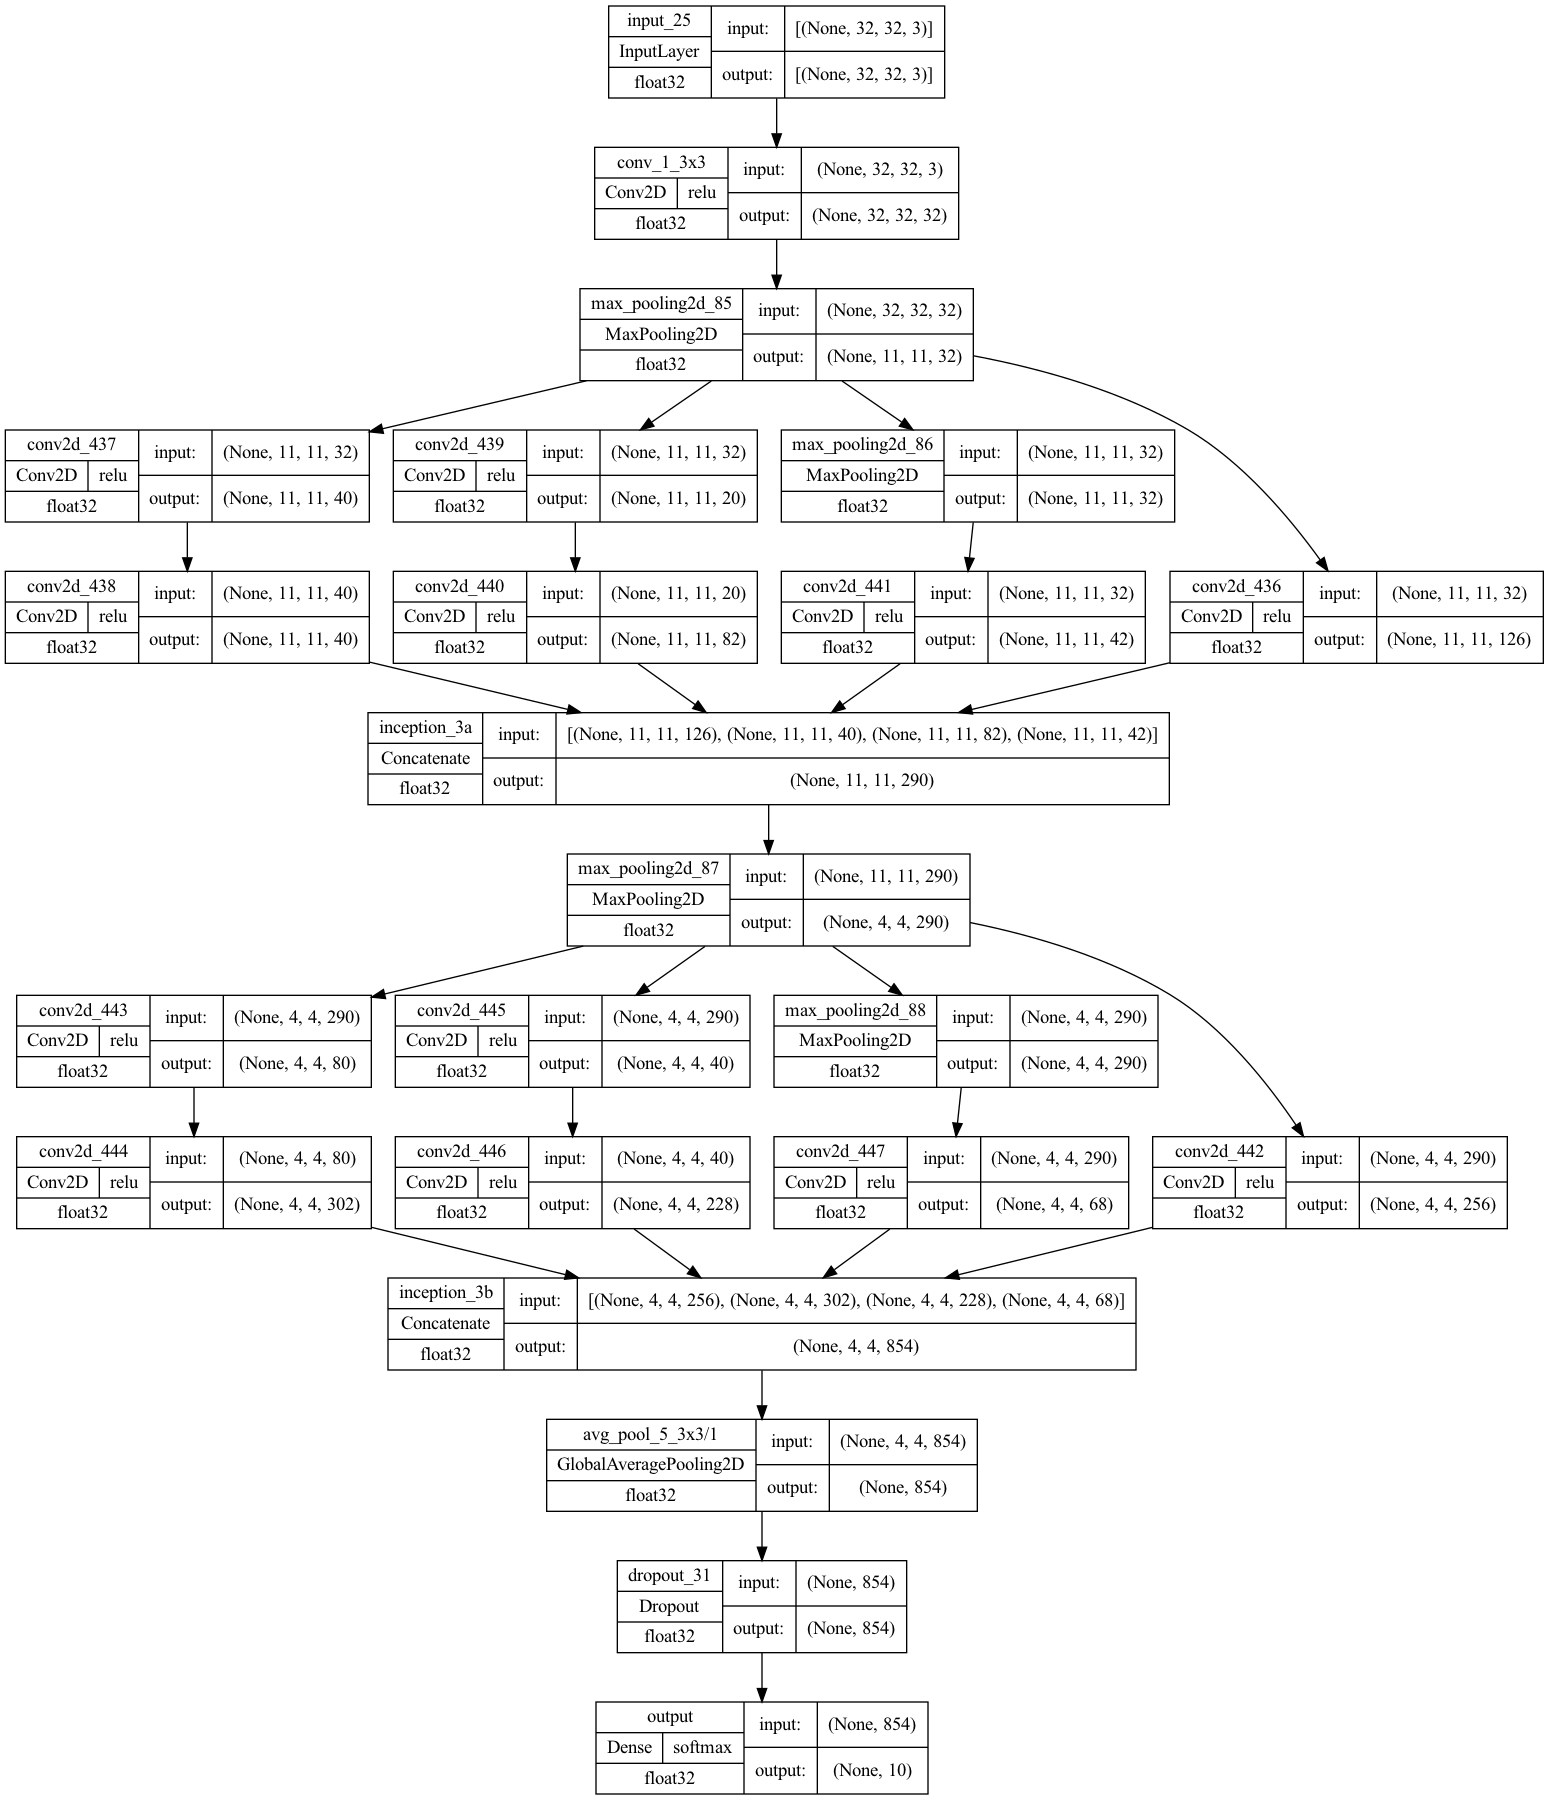

In [130]:
input_layer = Input(x_train_all.shape[1:])

x = Conv2D(32, (7, 7), strides=(2,2), padding='same', activation='relu', name='conv_1_3x3', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
# x = BatchNormalization(name="BNM1")(x)
x = MaxPool2D((2, 2), strides=3)(x)
x = inception_module(x,
                     filters_1x1=126,
                     filters_3x3_reduce=40,
                     filters_3x3=80,
                     filters_5x5_reduce=20,
                     filters_5x5=82,
                     filters_pool_proj=42,
                     name='inception_3a')
x = MaxPool2D((2, 2), strides=3)(x) 
x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=80,
                     filters_3x3=302,
                     filters_5x5_reduce=40,
                     filters_5x5=228,
                     filters_pool_proj=68,
                     name='inception_3b')
x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
# x = Flatten()(x)
x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

model4 = Model(input_layer, x, name='inception_user1')

plot_model(model4, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [83]:
model2.summary()

Model: "inception_user1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 32, 32, 32)   896         ['input_18[0][0]']               
                                                                                                  
 max_pooling2d_62 (MaxPooling2D  (None, 10, 10, 32)  0           ['conv_1_3x3[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_359 (Conv2D)            (None, 10, 10, 64)   2112        ['max_pooling2d_62[

In [84]:
x_train_all[0].shape

(32, 32, 3)

In [13]:
class MyCallback(Callback):
    def on_epoch_end(self, end, logs={}):
        if logs.get('val_acc') > 0.95:
            self.model.stop_training = True
            print('\n')
            print('목표 정확도 달성: 검증 정확도 %.4f' % logs.get('val_acc'))
my_callback = MyCallback()



def mdFit(model, num, X_train, y_train, my_callback) : # + best model select.

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', #No OneHot Encoding
              metrics=['acc'])
    model.summary()
       
    best_model_path = f"./bestModel/LeNet5/best_cnn_model{num}.h5" 
    save_best_model = ModelCheckpoint(best_model_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False)

    globals()[f'hist{num}'] = model.fit(
        x=X_train, y=y_train, batch_size=128, epochs=20, verbose=1,
        validation_split=0.2, callbacks=[my_callback ,save_best_model]) 
    # validation : (x_test, y_test)값을 가지고 와서 봐도 된다. 현재 0.2의 비율로 가져와서
    
    globals()[f'best_model{num}'] = load_model(best_model_path)
    globals()[f'best_model{num}'].summary()
    
    
def mdEval(model, x_tst, y_tst) :
    model.evaluate(x_tst, y_tst, batch_size=30, verbose=1)
    
def mdPred(model, X_tst) :
    result = model.predict(X_tst)
    return result

In [118]:
y_train_all.shape

(100000, 1)

In [119]:
x_train_all.shape

(100000, 32, 32, 3)

In [120]:
y_train_all.shape

(100000, 1)

In [14]:
mdFit(model, 0, X_train, y_train, my_callback)

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                     

 conv2d_78 (Conv2D)             (None, 14, 14, 24)   12312       ['inception_4a[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 14, 14, 512)  0          ['inception_4a[0][0]']           
 )                                                                                                
                                                                                                  
 conv2d_75 (Conv2D)             (None, 14, 14, 160)  82080       ['inception_4a[0][0]']           
                                                                                                  
 conv2d_77 (Conv2D)             (None, 14, 14, 224)  226016      ['conv2d_76[0][0]']              
                                                                                                  
 conv2d_79 (Conv2D)             (None, 14, 14, 64)   38464       ['conv2d_78[0][0]']              
          

 conv2d_103 (Conv2D)            (None, 7, 7, 32)     26656       ['max_pool_4_3x3/2[0][0]']       
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 7, 7, 832)   0           ['max_pool_4_3x3/2[0][0]']       
 )                                                                                                
                                                                                                  
 conv2d_100 (Conv2D)            (None, 7, 7, 256)    213248      ['max_pool_4_3x3/2[0][0]']       
                                                                                                  
 conv2d_102 (Conv2D)            (None, 7, 7, 320)    461120      ['conv2d_101[0][0]']             
                                                                                                  
 conv2d_104 (Conv2D)            (None, 7, 7, 128)    102528      ['conv2d_103[0][0]']             
          

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/Users/werther/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/werther/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/werther/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/werther/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/werther/opt/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/t4/vwr916y50fv3wcm0xlgfkyg00000gn/T/ipykernel_1039/4071853501.py", line 1, in <module>
      mdFit(model, 0, X_train, y_train, my_callback)
    File "/var/folders/t4/vwr916y50fv3wcm0xlgfkyg00000gn/T/ipykernel_1039/3358304379.py", line 24, in mdFit
      globals()[f'hist{num}'] = model.fit(
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 2098, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 5633, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [128,10] and labels shape [1280]
	 [[{{node sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_425436]

In [128]:
mdEval(best_model4, x_test, y_test)

334/334 [==============================] - 9s 27ms/step - loss: 1.2032 - acc: 0.6991


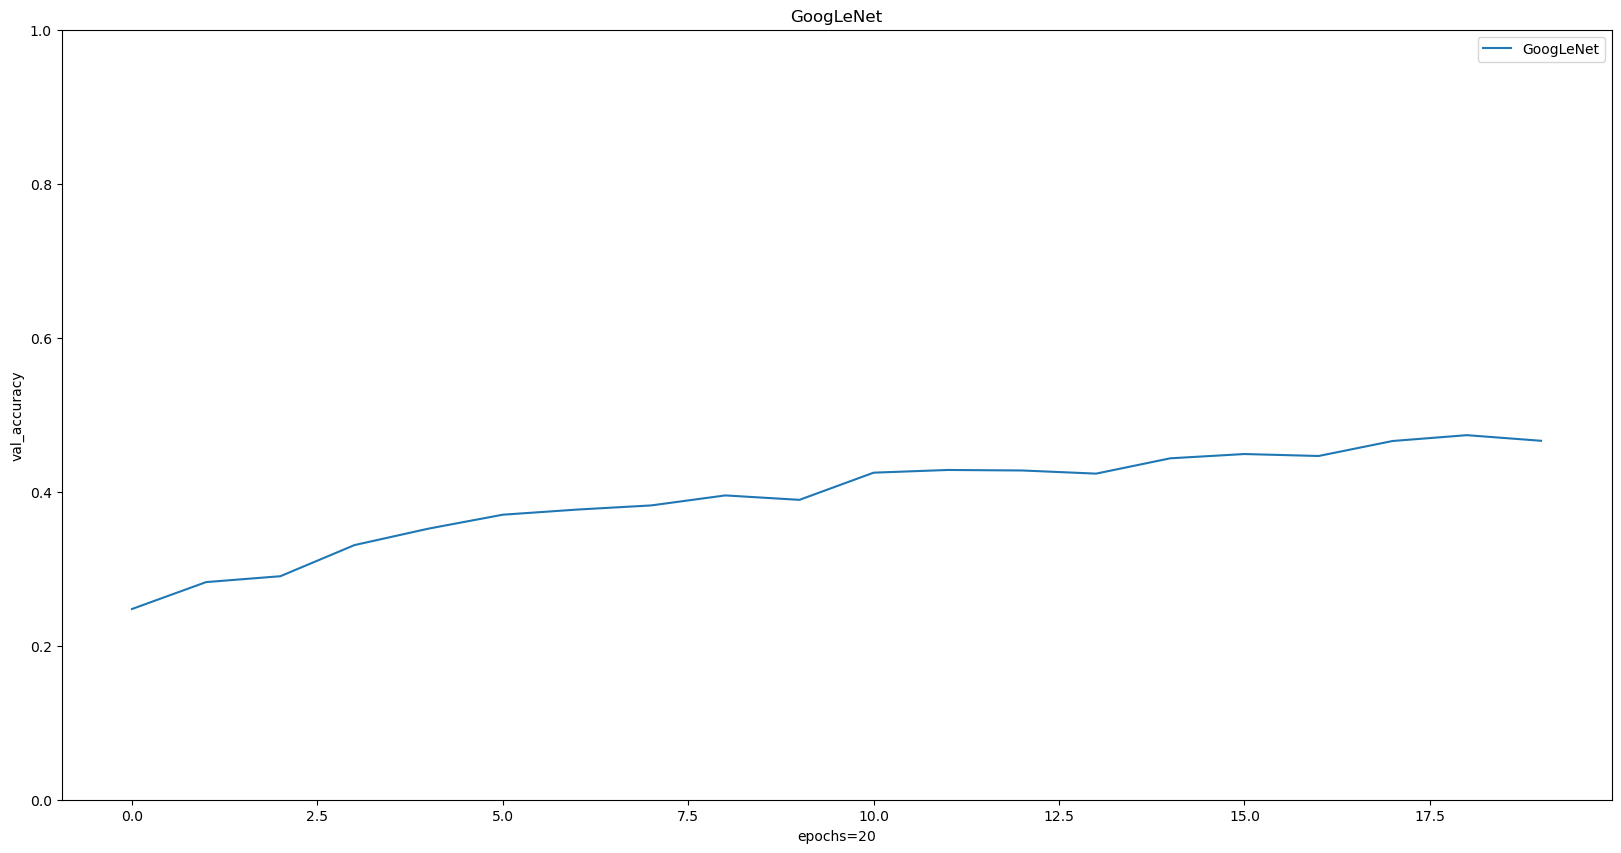

In [129]:
plt.figure(figsize=(20,10))
# plt.plot(hist1.history['val_loss'], label='val_loss1')
# plt.plot(hist2.history['val_loss'], label='val_loss2')
# plt.plot(hist3.history['val_loss'], label='val_loss3')
# plt.plot(hist4.history['val_loss'], label='val_loss4')
plt.plot(hist4.history['val_acc'], label='GoogLeNet')
# plt.plot(hist4.history['val_acc'], label='ESK')
# plt.plot(hist1.history['val_accuracy'], label='Flatten, 2hd')
# plt.plot(hist2.history['val_accuracy'], label='Flatten, 3hd')
# plt.plot(hist3.history['val_accuracy'], label='Flatten, 4hd')
# plt.plot(hist4.history['val_accuracy'], label='Conv2D')
# plt.plot(hist5.history['val_accuracy'], label='Conv2D_2')
plt.ylim(0, 1)
plt.title("GoogLeNet")
plt.ylabel("val_accuracy")
plt.xlabel("epochs=20")
plt.legend()


In [1]:
!pip install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 13.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 26.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.0 MB/s eta 0:00:00
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31671 sha256=15f142cd382d4b5bc9e3a3cf59f76cb1be9e5116221709bcba781925d04f8d29
  Stored in directory: /Users/werther/Library/Caches/pip/wheels/0e/cf/f7/60996297fcab092be8eda6268bb6662dd6320f2fb685b9f872
Successfully built python-multipart
  Attempting uninstall: watchdog
    Found existing installation: watchdog 2.1.6
    Uninstalling watchdog-2.1.6:
      Successfully uninstalled watchdog-2.1.6
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.2.0
    Uninstalling Pillow-9.2.0:
      Successfully uninstalled Pillow-9.2.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
      Successfully uni

In [3]:
# 누끼 따주는
import rembg
import imgaug

In [2]:
# imgaug : augmentation 기능
!pip install imgaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.7 MB/s eta 0:00:0000:0100:01


# Parse

In [33]:
import os
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET
import argparse

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            value = (filename,
                    width,
                    height,
                    member.find('name').text,
                    int(bndbox.find('xmin').text),
                    int(bndbox.find('ymin').text),
                    int(bndbox.find('xmax').text),
                    int(bndbox.find('ymax').text),
                    )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                  'class', 'xmin', 'ymin', 'xmax', 'ymax']
    
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [34]:
df = xml_to_csv('./image/')
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,AirPodsProCase.png,926,694,airpodspro,161,89,777,548


# rembg

In [21]:
from rembg.bg import remove as remove_bg

import io
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
def show_rembg(path):
    fig = plt.figure(figsize=(10, 10))
    
    # show original image
    fig.add_subplot(1, 2, 1)
    orig_img = Image.open(path)
    plt.imshow(orig_img)
    
    # show bg removed image
    fig.add_subplot(1, 2, 2)
    f = np.fromfile(path)
    
    started = time.time()
    result = remove_bg(f)
    elapsed = time.time() - started
    print(f'it takes {elapsed} seconds for removing bg.')
    
    img = Image.open(io.BytesIO(result)).convert("RGBA")
    plt.imshow(img)
    

it takes 1.0306761264801025 seconds for removing bg.


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f9c812bcea0>

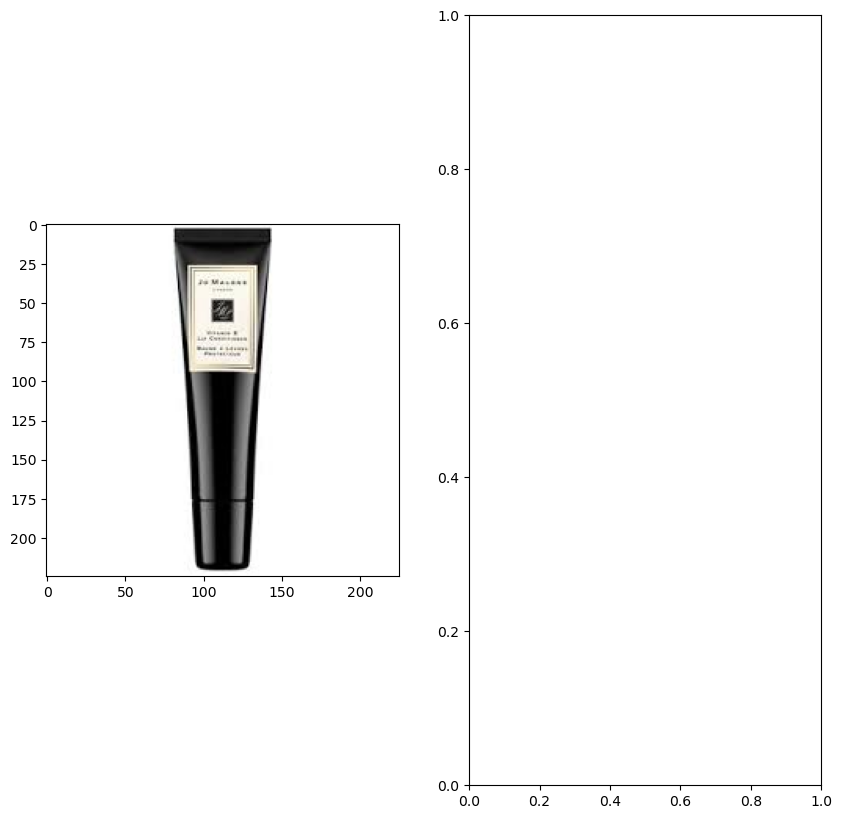

In [25]:
show_rembg('./image/jomalone.jpeg')

In [ ]:
globals()['imgs'] = []

# pepsi
pepsi_zero_355_path = '/Users/werther/221212_Project1/pepsi_zero_355/'
pepsi_zero_355_xml_path = '/Users/werther/221212_Project1/pepsi_zero_355/xml/'
pepsi_zero_355_xml_df = checkAll(pepsi_zero_355_path, pepsi_zero_355_xml_path, 5)

pepsi_zero_500_path = '/Users/werther/221212_Project1/pepsi_zero_500/'
pepsi_zero_500_xml_path = '/Users/werther/221212_Project1/pepsi_zero_500/xml/'
pepsi_zero_500_xml_df = checkAll(pepsi_zero_500_path, pepsi_zero_500_xml_path, 6)

pepsi_250_path = '/Users/werther/221212_Project1/pepsi_250/'
pepsi_250_xml_path = '/Users/werther/221212_Project1/pepsi_250/xml/'
pepsi_250_xml_df = checkAll(pepsi_250_path, pepsi_250_xml_path, 3)

pepsi_355_path = '/Users/werther/221212_Project1/pepsi_355/'
pepsi_355_xml_path = '/Users/werther/221212_Project1/pepsi_355/xml/'
pepsi_355_xml_df = checkAll(pepsi_355_path, pepsi_355_xml_path, 4)

# coca
coca_250_path = '/Users/werther/221212_Project1/coca_cola_250/'
coca_250_xml_path = '/Users/werther/221212_Project1/coca_cola_250/xml/'
coca_250_xml_df = checkAll(coca_250_path, coca_250_xml_path, 1)

coca_350_path = '/Users/werther/221212_Project1/coca_cola_350/'
coca_350_xml_path = '/Users/werther/221212_Project1/coca_cola_350/xml/'
coca_350_xml_df = checkAll(coca_350_path, coca_350_xml_path, 2)

coca_z_250_path = '/Users/werther/221212_Project1/coca_cola_zero_250/'
coca_z_250_xml_path = '/Users/werther/221212_Project1/coca_cola_zero_250/xml/'
coca_z_250_xml_df = checkAll(coca_z_250_path, coca_z_250_xml_path, 9)

coca_z_355_path = '/Users/werther/221212_Project1/coca_cola_zero_355/'
coca_z_355_xml_path = '/Users/werther/221212_Project1/coca_cola_zero_355/xml/'
coca_z_355_xml_df = checkAll(coca_z_355_path, coca_z_355_xml_path, 10)

#chilsung
chil_250_path = '/Users/werther/221212_Project1/chilsung_250/'
chil_250_xml_path = '/Users/werther/221212_Project1/chilsung_250/xml/'
chil_250_xml_df = checkAll(chil_250_path, chil_250_xml_path, 11)

chil_355_path = '/Users/werther/221212_Project1/chilsung_355/'
chil_355_xml_path = '/Users/werther/221212_Project1/chilsung_355/xml/'
chil_355_xml_df = checkAll(chil_355_path, chil_355_xml_path, 12)

# pocari
pocari_240_path = '/Users/werther/221212_Project1/pocari_240/'
pocari_240_xml_path = '/Users/werther/221212_Project1/pocari_240/xml/'
pocari_240_xml_df = checkAll(pocari_240_path, pocari_240_xml_path, 7)

pocari_620_path = '/Users/werther/221212_Project1/pocari_620/'
pocari_620_xml_path = '/Users/werther/221212_Project1/pocari_620/xml/'
pocari_620_xml_df = checkAll(pocari_620_path, pocari_620_xml_path, 8)

# sprite
spr_250_path = '/Users/werther/221212_Project1/sprite_250/'
spr_250_xml_path = '/Users/werther/221212_Project1/sprite_250/xml/'
spr_250_xml_df = checkAll(spr_250_path, spr_250_xml_path, 13)

spr_350_path = '/Users/werther/221212_Project1/sprite_350/'
spr_350_xml_path = '/Users/werther/221212_Project1/sprite_350/xml/'
spr_350_xml_df = checkAll(spr_350_path, spr_350_xml_path, 14)


# non_object
path = '/Users/werther/221212_Project1/non_object/'
non_df = checkAll(path, is_non=True)